# Hybrid CNN-RNN with Attention Mechanism

In [ ]:
!pip install tensorflow

In [ ]:
# Load data
data = pd.read_csv('data.csv', index_col='prename')
pheno = pd.read_csv('pheno.csv', index_col='prename')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 112, 1)]             0         []                            
                                                                                                  
 conv1d_4 (Conv1D)           (None, 110, 8)               32        ['input_2[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 110, 8)               32        ['conv1d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv1d_5 (Conv1D)           (None, 110, 8)               200       ['batch_normalization_2[

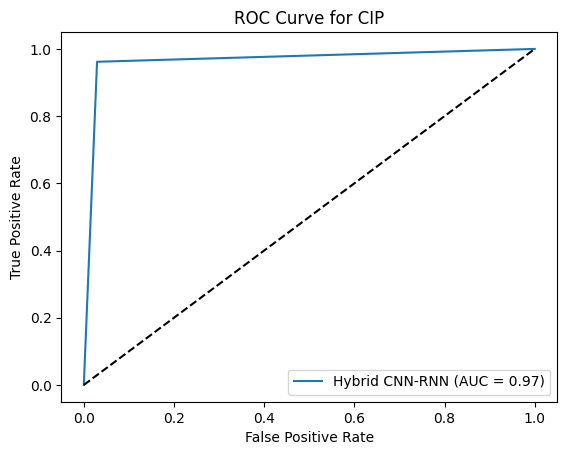


Classification for CTX:
6/6 [==============================] - 0s 22ms/step
Hybrid CNN-RNN Model Accuracy: 0.8665018541409147

Hybrid CNN-RNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       451
           1       0.86      0.84      0.85       358

    accuracy                           0.87       809
   macro avg       0.87      0.86      0.86       809
weighted avg       0.87      0.87      0.87       809



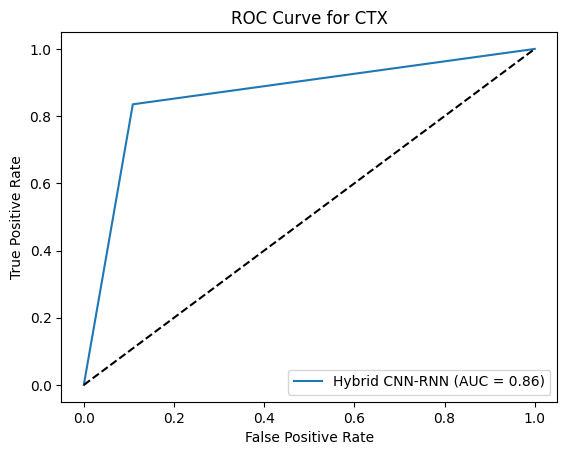


Classification for CTZ:
6/6 [==============================] - 0s 29ms/step
Hybrid CNN-RNN Model Accuracy: 0.9060568603213844

Hybrid CNN-RNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       533
           1       0.85      0.87      0.86       276

    accuracy                           0.91       809
   macro avg       0.89      0.90      0.90       809
weighted avg       0.91      0.91      0.91       809



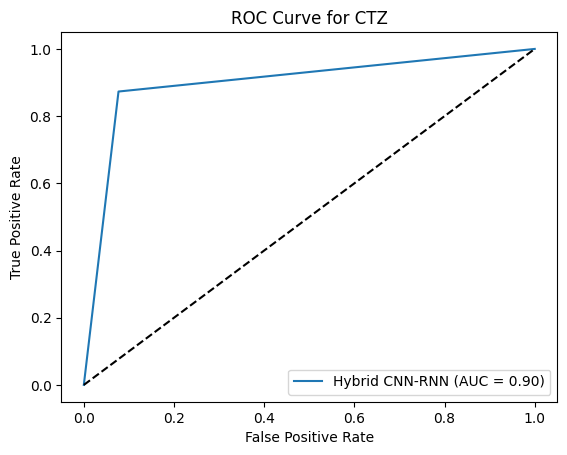


Classification for GEN:
6/6 [==============================] - 0s 26ms/step
Hybrid CNN-RNN Model Accuracy: 0.8504326328800988

Hybrid CNN-RNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       621
           1       0.67      0.70      0.69       188

    accuracy                           0.85       809
   macro avg       0.79      0.80      0.79       809
weighted avg       0.85      0.85      0.85       809



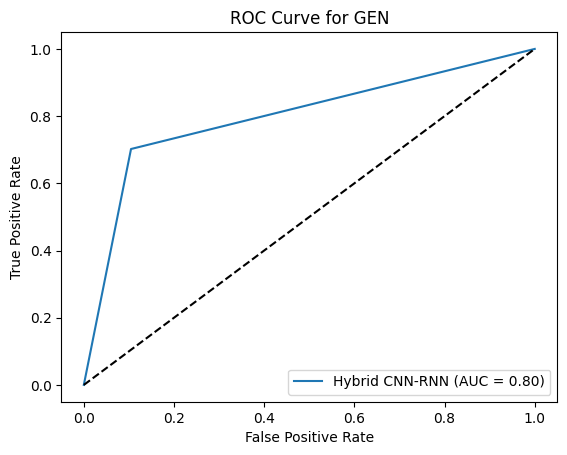

In [ ]:
#HYBRID CNN-RNN with attention Mechanism
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Reshape, Concatenate, Permute, Multiply
from tensorflow.keras.utils import to_categorical

# Standardize features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=0.95)
data_pca = pca.fit_transform(data_scaled)

# Define input shape
input_shape = (data_pca.shape[1], 1)
input_layer = Input(shape=input_shape)

# Define CNN layers
conv1 = Conv1D(filters=8, kernel_size=3, activation='relu')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu')(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv1 = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)
conv1 = Flatten()(conv1)

# Define RNN layers
rnn_input = Reshape((-1, 16))(conv1)
lstm1 = LSTM(128, return_sequences=True)(rnn_input)
lstm1 = Dropout(0.5)(lstm1)
lstm2 = LSTM(64, return_sequences=True)(lstm1)
lstm2 = Dropout(0.5)(lstm2)
lstm3 = LSTM(32, return_sequences=True)(lstm2)
lstm3 = Dropout(0.5)(lstm3)

# Attention mechanism
attention = Dense(1, activation='tanh')(lstm3)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(32)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([lstm3, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2))(sent_representation)

# Concatenate CNN and RNN outputs with attention
concatenated = Concatenate()([conv1, sent_representation])

# Define dense layers
dense1 = Dense(128, activation='relu')(concatenated)
dense1 = Dropout(0.2)(dense1)

# Output layer
output_layer = Dense(4, activation='softmax')(dense1)

# Define and compile model
combined_model = Model(inputs=input_layer, outputs=output_layer)
combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(combined_model.summary())

labels = ['CIP', 'CTX', 'CTZ', 'GEN']
for label in labels:
    print(f"\nClassification for {label}:")
    y = pheno[label]
    y_encoded = to_categorical(y, num_classes=4)

    # Perform 5-fold cross-validation and prediction
    kf = KFold(n_splits=5)
    combined_pred = np.zeros_like(y_encoded)
    for train_index, test_index in kf.split(data_pca):
        X_train, X_test = data_pca[train_index], data_pca[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Train combined model
        combined_model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
                           epochs=50, batch_size=32, verbose=0)
        combined_pred[test_index] = combined_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

    # Convert predictions back to labels
    combined_pred_labels = np.argmax(combined_pred, axis=1)

    # Calculate accuracy scores
    combined_accuracy = accuracy_score(y, combined_pred_labels)

    # Print accuracy score
    print("Hybrid CNN-RNN Model Accuracy:", combined_accuracy)

    # Generate classification report
    combined_report = classification_report(y, combined_pred_labels)

    # Print classification report
    print("\nHybrid CNN-RNN Model Classification Report:")
    print(combined_report)

    # Calculate ROC curve and AUC for combined model
    fpr, tpr, _ = roc_curve(y, combined_pred_labels)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for combined model
    plt.figure()
    plt.plot(fpr, tpr, label=f'Hybrid CNN-RNN (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {label}')
    plt.legend(loc='lower right')
    plt.show()